# Model training

In [15]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [3]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split dataset
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']

# Reduce dataset size for test purpose
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.95, random_state = 42, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42, stratify=y_train)

0    11696
1     1095
Name: HeartDisease, dtype: int64

## Global variables

In [50]:
scorer = make_scorer(fbeta_score, beta=2)

## Methods

In [68]:
# Function that provides evaluation for passed model estimator with different parameters
def model_eval(estimator, parameters, X_train, y_train, X_test, y_test, scoring=scorer, verbose=0):
    # specify the cross validation
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator,
                                         param_grid=parameters,
                                         scoring=scoring,
                                         cv=cv,
                                         return_train_score=False,
                                         verbose=verbose
                                         )
    # training and prediction
    grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    # evaluation of the model
    display(grid_search_estimator.best_params_)
    display(get_scores(y_test, y_predicted))
    display(plot_roc(y_test, y_predicted))

    if estimator==forest_estimator:
        display(plot_feature_importance(grid_search_estimator.best_estimator_))

    if estimator==nn_estimator:
        display(plot_learning_curve(grid_search_estimator, cv, scoring))

# Returns scores for passed parameters
def get_scores(y_test, y_predicted):
    return {'accuracy': accuracy_score(y_test, y_predicted),
            'recall': recall_score(y_test, y_predicted),
            'precision': precision_score(y_test, y_predicted),
            'f1_score': f1_score(y_test, y_predicted),
            'f2_score': fbeta_score(y_test, y_predicted, beta=2)}

# Plot ROC for passed parameters
def plot_roc(y_test, y_predicted):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic (ROC)')

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)

    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return figure

# Plot feature importance for passed parameters
def plot_feature_importance(estimator):
    figure = plt.figure()
    plt.subplots(1, figsize=(10,10))
    plt.title('Feature Importance')
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh')
    return figure

# Plot learning curve for passed parameters
def plot_learning_curve(grid_search_estimator, cv, scoring):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator = grid_search_estimator,
        X = X_test,
        y = y_test, cv = cv,
        scoring = scoring)

    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,40)

## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

{'accuracy': 0.8420888055034397,
 'recall': 0.08029197080291971,
 'precision': 0.08,
 'f1_score': 0.08014571948998178,
 'f2_score': 0.08023340627279359}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

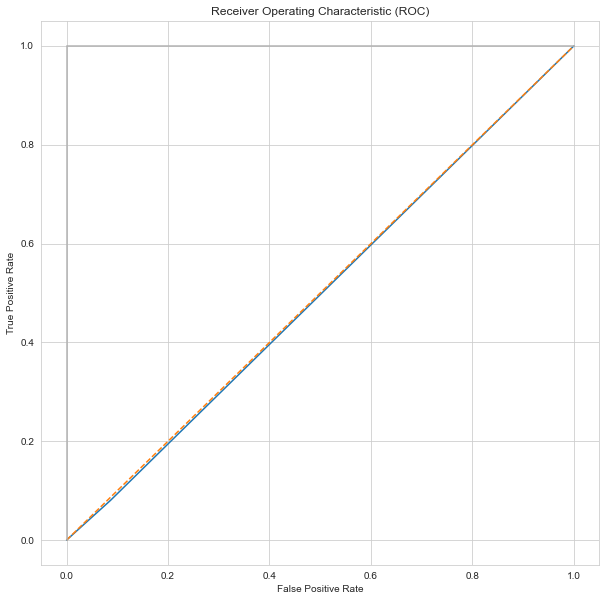

In [69]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

display(get_scores(y_test, y_predicted))
display(plot_roc(y_test, y_predicted))

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Knn

{'n_neighbors': 3}

{'accuracy': 0.9040025015634772,
 'recall': 0.14233576642335766,
 'precision': 0.35135135135135137,
 'f1_score': 0.20259740259740258,
 'f2_score': 0.16155758077879037}

<Figure size 432x288 with 0 Axes>

None

<Figure size 432x288 with 0 Axes>

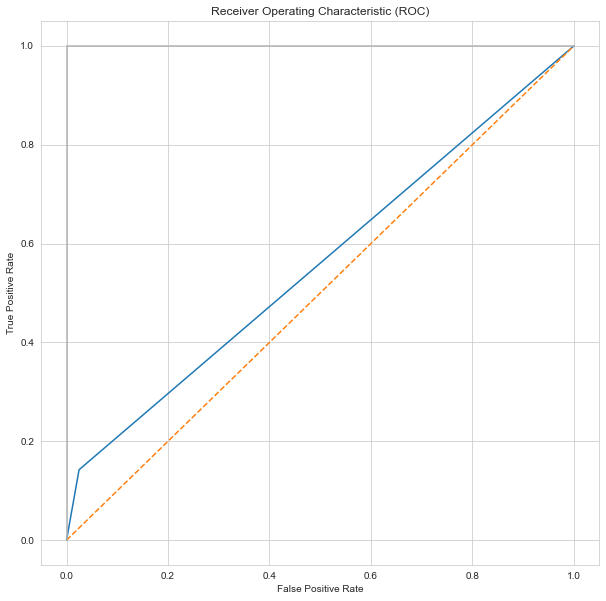

In [70]:
# create an estimator
knn_estimator = KNeighborsClassifier()

# specify the parameter grid
parameters = {
    'n_neighbors': [2, 3, 5]
}

# train model and display evaluation
display(model_eval(estimator=knn_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))


## Random Forest

{'class_weight': {0: 1, 1: 2}, 'n_estimators': 3}

{'accuracy': 0.8943089430894309,
 'recall': 0.1897810218978102,
 'precision': 0.30952380952380953,
 'f1_score': 0.23529411764705882,
 'f2_score': 0.20569620253164556}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

None

<Figure size 432x288 with 0 Axes>

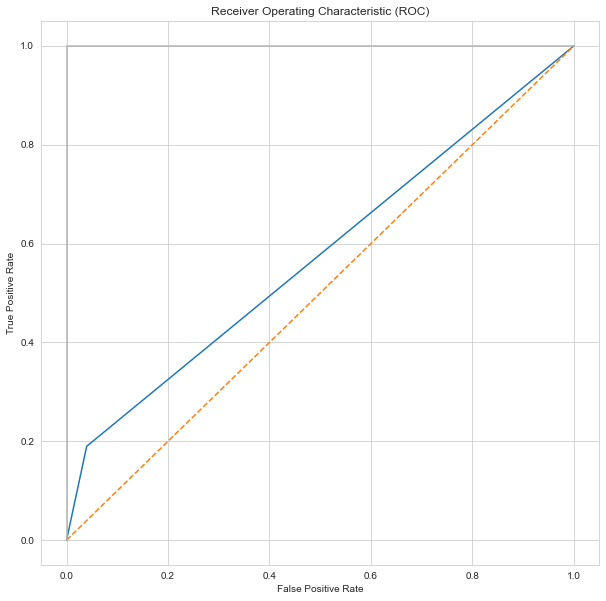

<Figure size 432x288 with 0 Axes>

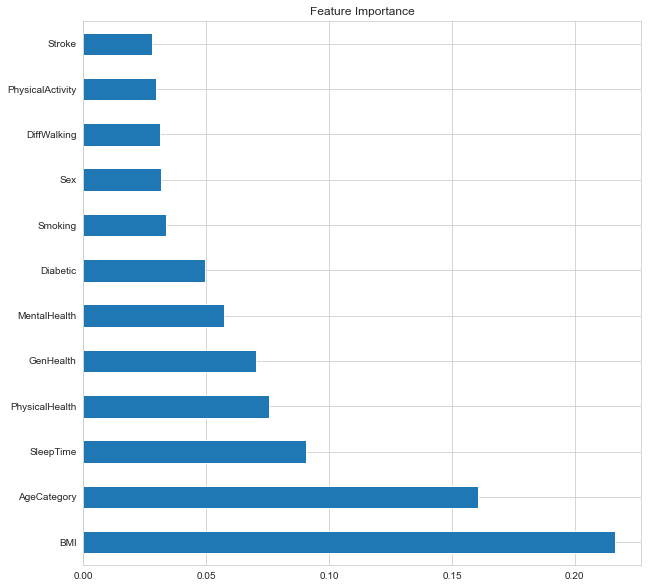

In [71]:
# create an estimator
forest_estimator = RandomForestClassifier()

# specify the parameter grid
parameters = {
    'class_weight': [{0:1, 1:2}, {0:1, 1:1}],
    'n_estimators': [2, 3, 4, 5]
}

# train model and display evaluation
display(model_eval(estimator=forest_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))

## Support Vector Machine

In [ ]:
# create an estimator
svc_estimator = SVC(random_state=0)

# specify the parameter grid
parameters = {
    'kernel': ['linear', 'poly']
}

# train model and display evaluation
display(model_eval(estimator=svc_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))

## Neural Net

In [49]:
# create an estimator
nn_estimator = MLPClassifier(random_state=1, max_iter=300)

# specify the parameter grid
# TODO JG: adjust parameter
parameters = {
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}

# train model and display evaluation
display(model_eval(estimator=nn_estimator, parameters=parameters, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test))

Best parameter: 
{'activation': 'identity'}


NameError: name 'learning_curve' is not defined